### Restricted Boltzman Machine approach for Collaborative Filtering.
The same has been applied on Netflix dataset.

References:<br>
https://www.cs.toronto.edu/~rsalakhu/papers/rbmcf.pdf<br>
<br>
Blogs Refered:<br>
http://blog.echen.me/2011/07/18/introduction-to-restricted-boltzmann-machines/<br>
<br>
Repository refered to:<br>
https://github.com/srp98/Movie-Recommender-using-RBM<br>
https://github.com/pinkeshbadjatiya/movie-reco-using-RBM<br>
https://github.com/echen/restricted-boltzmann-machines<br>

##### My understanding of the topic by Salakhutdinov, Mnih and Hinton:<br>
A 2 layer undirected RBM is used to model user rating data. The idea is to use an RBM for each user with shared weights for users rating the smae movies. Based on values at all the units , one can decide which one should be activated. The first layer is called the **visible layer** and the second the **hidden layer**. 
<br>
A different RBM is used for each user under the following constraints:

* Every RBM has the same number of hidden units, but an RBM has active softmax visible units only for the items rated by that user
* The connection weights (and biases) between the softmax visible layer and the hidden layer are tied .If two users have rated the same movie, their two RBM's must use the same weights between the softmax unit for that movie and the hidden units

To ensure binary mappings , nodes with ratings from 1 to k are made for each movie a user is rating. Each node is activated or deactivated based on the value it is looking for.<br><br>
Node 1 is looking for rating 1 for movie 1 <br>
Node 2 is looking for rating 2 for movie 1 itself<br>
...... <br>
Node K is looking for rating k for movie 1<br>
Node K+1 is looking for rating 1 for movie 2<br>
....(and so on...)<br>
<br>
Missing ratings are not dealt with. They are left blank . The mathematics will take care of it.
The whole idea behind an RBM is that it can **reconstruct the input**. In the training process we ignore the reconstructions.The network is trained by optimizing the **Contrastive Divergence(CD) (Similar to approximate gradient descent)**.


In [1]:
#importing all necessary librarys
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
#Reading files

import numpy as np
import pandas as pd

r_cols=['user_id', 'item_id', 'rating', 'timestamp']
data_df = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

m_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url','unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item_df = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols,
                     encoding='latin-1')

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
user_df = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1', parse_dates=True) 

g_cols=['genre','genre_id']
genre_df=pd.read_csv('ml-100k/u.genre', sep='|', names=g_cols,
                     encoding='latin-1')

o_cols=['occupation']
occupation_df=pd.read_csv('ml-100k/u.occupation', sep='|', names=o_cols,
                     encoding='latin-1')
new_movie_df = pd.read_csv('ml-100k/item_cc_genre.csv')

In [3]:
print(data_df.head())

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [4]:
user_temp = data_df['user_id']
user_group = data_df['user_id'].unique()
print(len(user_temp))#1,00,000 ratings (1-5)
print(len(user_group)) #943 users

100000
943


In [5]:
user_g = data_df.groupby(['user_id'])

In [6]:
len(item_df) #number of unique movies

1682

In [7]:
training=[]
movie_rated_ids=[]
for user_id, item_id in user_g:
    temp = [0]*len(item_df) #A list of 0's for all the movies.
    l=[]
    for num,movie in item_id.iterrows():
        l.append(movie['item_id'])
        temp[movie['item_id']-1]=movie['rating']/5.0 #Normalize the score for movies.
        #print(movie)
    training.append(temp)
    movie_rated_ids.append(l)
#print(training)

##### My Understanding of tensor flow & RBM's in general:<br>

Every vector is a tensor here. tf.placeholder is used to allocate memory to a tensor with type float32. Its used to feed actual training examples.<br>
**tf.float32** is a single precession which is stored in 32 bits. tf.float32 allows you to store more content in memory.<br>
During the Contrastive Divergence , an approximate gradient descent is performed. During this calculation we have to use **Gibb's sampling** to sample from the model distribution.<br>
**The basis for using the sampling is to not wait for Markov chains ( CD uses them) to converge. Makes the process faster as samples are obtained after k-steps.**<br>
**tf.math.sigmoid** : computes sigmoid of input element-wise. <br>
**tf.random.uniform** : outputs random values from a uniform distribution.<br>
**tf.sign** : tells element-wise inidcation of sign of a number.<br>
**tf.nn.relu** : used here to avoid vanishing gradient problem.Adds compexity to the o/p values. <br>
**tf.math.reduce_mean** : Compute means of elemts across dimensions of a tensor. <br>
**tf.session** : A session object controls the environment in which the Tensor objects are evaluated.

In [8]:
hiddenUnits = 50 # Number of features learned in 50. It is constant for all users
visibleUnits = len(item_df) #No of unique movies

v = tf.placeholder(tf.float32, [visibleUnits])  
h = tf.placeholder(tf.float32, [hiddenUnits])  
W_matrix = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits])  # Weight Matrix

#print(W)

# Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
#print(v0)

temp_h0 = tf.nn.sigmoid(tf.matmul(v0, W_matrix) + h)  # Visible layer activation
#print(temp_h0)
h0 = tf.nn.relu(tf.sign(temp_h0 - tf.random_uniform(tf.shape(temp_h0))))  # Gibb's Sampling

# Reconstruction
temp_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W_matrix)) + v)  # Hidden layer activation
v1 = tf.nn.relu(tf.sign(temp_v1 - tf.random_uniform(tf.shape(temp_v1)))) # Gibb's Sampling again 
h1 = tf.nn.sigmoid(tf.matmul(v1, W_matrix) + h)

In [9]:
#Setting parameters

# Learning rate
alpha = 1.0

# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases
update_w = W_matrix + alpha * CD
update_v = v + alpha * tf.reduce_mean(v0 - v1, 0)
update_h = h + alpha * tf.reduce_mean(h0 - h1, 0)

# Set the error function, here we use Mean Absolute Error Function
err = v0 - v1
err_sum = tf.reduce_mean(err*err)

In [10]:
#Initialize our Variables with Zeroes using Numpy Library

# Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Current visible unit biases
cur_v = np.zeros([visibleUnits], np.float32)

# Current hidden unit biases
cur_h = np.zeros([hiddenUnits], np.float32)

# Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Previous visible unit biases
prv_v = np.zeros([visibleUnits], np.float32)

# Previous hidden unit biases
prv_h = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.35285732
0.32627806
0.24930438
0.216911
0.18606098
0.1658076
0.15208322
0.1447761
0.13924025
0.13818257
0.13780415
0.1349682
0.13428552
0.13374269
0.13350525
0.13342784
0.13319747
0.13318776
0.1287383
0.12913474
0.12508726
0.12585467
0.12516217
0.12374917
0.122449
0.11956312
0.117606774
0.11825628
0.11662702
0.115153246
0.114412576
0.11355816
0.11201668
0.1098466
0.11049599
0.10784034
0.10711164
0.1060957
0.104747765
0.104411855
0.10364067
0.102084555
0.103332244
0.10168773
0.10072652
0.10025897
0.09960821
0.097912
0.09833756
0.09720688


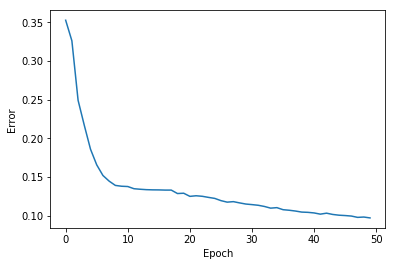

In [11]:
# Train RBM with 50 Epoch. Printing the error after each epoch
epochs = 50
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip(range(0, len(training), batchsize), range(batchsize, len(training), batchsize)):
        batch = training[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W_matrix: prv_w, v: prv_v, h: prv_h})
        cur_v = sess.run(update_v, feed_dict={v0: batch, W_matrix: prv_w, v: prv_v, h: prv_h})
        cur_h = sess.run(update_h, feed_dict={v0: batch, W_matrix: prv_w, v: prv_v, h: prv_h})
        prv_w = cur_w
        prv_vb = cur_v
        prv_hb = cur_h
    errors.append(sess.run(err_sum, feed_dict={v0: training, W_matrix: cur_w, v: cur_v, h: cur_h}))
    print(errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [12]:
#inputting the user ID
inp = int(input("Enter the UserID : "))
list_of_his_watched_movies = movie_rated_ids[inp-1] #0 based index
#print(list_of_his_watched_movies)

print("List of the movies he/she rated: ")
list_of_his_watched_movies = [m-1 for m in list_of_his_watched_movies]
df_of_his_watched_movies = item_df.iloc[list_of_his_watched_movies,[0,1,2]]

inputUser=[training[inp]] #Needed for feeding in to the network.
#df_of_his_watched_movies.columns=['item_id','movie_title','release_date']
df_of_his_watched_movies.head()

Enter the UserID : 20
List of the movies he/she rated: 


,movie_id,movie_title,release_date
287,288,Scream (1996),20-Dec-1996
207,208,Young Frankenstein (1974),01-Jan-1974
10,11,Seven (Se7en) (1995),01-Jan-1995
175,176,Aliens (1986),01-Jan-1986
117,118,Twister (1996),10-May-1996


In [13]:
# Feeding in the User and Reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W_matrix) + h)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W_matrix)) + v)

feed = sess.run(hh0, feed_dict={v0: inputUser, W_matrix: prv_w, h: prv_h})
reconstruction = sess.run(vv1, feed_dict={hh0: feed, W_matrix: prv_w, v: prv_v})

In [14]:
# Sort the recommendations based on score. Display top 10.
copy_item_df = item_df
copy_item_df["Generated Score"] = reconstruction[0]
copy_item_df.sort_values(["Generated Score"], ascending=False).head(10)

# Merging copy_item_df with ratings_df by item_id
merged_item_df = copy_item_df.merge(df_of_his_watched_movies, on='movie_id', how='outer', indicator=True)
merged_item_df = merged_item_df[merged_item_df['_merge'] == 'left_only'] #Choosing only not watched movies.
# Dropping unnecessary columns
merged_item_df= merged_item_df.iloc[:,[0,1,2,24]]

print_merged_item_df = merged_item_df.merge(new_movie_df, on='movie_id', how='inner', indicator=True)
print_merged_item_df = print_merged_item_df.iloc[:,[0,5,6,3,2,4,8,9,10]]
print('List of movies suggested to watch: ')
# The final recommendations
print_merged_item_df.sort_values(['Generated Score'], ascending=False).head(10)

List of movies suggested to watch: 


,movie_id,movie_title,year,Generated Score,release_date_x,genre,director,actor1,actor2
88,100,Fargo,1997,0.998510,14-Feb-1997,Crime Drama Thriller,Joel Coen,William H. Macy,Frances McDormand
50,56,Pulp Fiction,1994,0.998243,01-Jan-1994,Crime Drama,Quentin Tarantino,John Travolta,Samuel L. Jackson
207,234,Jaws,1975,0.947717,01-Jan-1975,Action Horror,Steven Spielberg,Roy Scheider,Robert Shaw
5,7,Twelve Monkeys,1995,0.931755,01-Jan-1995,Drama Sci-Fi,Terry Gilliam,Bruce Willis,Madeleine Stowe
9,12,"Usual Suspects, The",1995,0.925200,14-Aug-1995,Crime Thriller,Bryan Singer,Stephen Baldwin,Kevin Spacey
72,79,"Fugitive, The",1993,0.924512,01-Jan-1993,Action Thriller,Andrew Davis,Harrison Ford,Tommy Lee Jones
191,218,Cape Fear,1991,0.914609,01-Jan-1991,Thriller,Martin Scorsese,Robert De Niro,Nick Nolte
176,200,"Shining, The",1980,0.895197,01-Jan-1980,Horror,Stanley Kubrick,Jack Nicholson,Shelley Duvall
163,185,Psycho,1960,0.893032,01-Jan-1960,Horror Romance Thriller,Alfred Hitchcock,Anthony Perkins,Janet Leigh
410,447,Carrie,1976,0.876994,01-Jan-1976,Horror,Brian De Palma,Sissy Spacek,John Travolta


##### User with ID 20 has watched more movies belonging to the horror genre. The majority of movies suggested by the model is also in this category.